In [1]:
import pandas as pd
import numpy as np
import pysal as ps
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point

%matplotlib inline

/Users/brianconnor/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


# Spatial Data Analysis

### Recap of our lesson on SDA:

- Loaded up a shape file and plotted the coordinates
- Used PySAL to plot the outlines of states as a heatmap of median income
- Used Moran' I test to detect correlation in income data between states
    - This test is based on given "weights"
    - Weights can be added through PySAL based on distance
- Built a linear regression model that did *something*?

### But does anyone remember this stuff?

Does anyone care? What's a shape file? Is that an "I" or an "l"?

One thing we intentionally skipped over in our lesson was GeoPandas (for dependency issues, and honestly probably a good call). But we're gonna use it now.


### Why use GeoPandas?
- It can give visuals of raw coordinates during EDA
- Generalizable to other packages
- Useful built-in and compatible packages

In our lesson repo, there is an extra "geopandas practice" notebook that has some good examples of working with prepackaged GeoPandas files, but what if you're working with data that doesn't fit nicely with those packages?

### Let's start with something we actually know

In [2]:
import pandas as pd
# good old pandas

In [3]:
spray_csv = "./data/spray.csv"
spray = pd.read_csv(spray_csv)
# oh no

In [4]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


#### How do we get from Pandas to GeoPandas?

First you need to make a single coordinates column with both longitude and latitude

In [5]:
spray["coordinates"] = list(zip(spray.Longitude, spray.Latitude)) # zip combines lists by index into tuples
spray[["coordinates"]].head(10)

,coordinates
0,"(-88.0891633333333, 42.3916233333333)"
1,"(-88.0891633333333, 42.3913483333333)"
2,"(-88.0891566666667, 42.3910216666667)"
3,"(-88.0891583333333, 42.3906366666667)"
4,"(-88.0888583333333, 42.390409999999996)"
5,"(-88.08831500000001, 42.390395)"
6,"(-88.0880016666667, 42.3906733333333)"
7,"(-88.0880016666667, 42.391026666666704)"
8,"(-88.0880033333333, 42.391403333333294)"
9,"(-88.08799499999999, 42.391718333333294)"


The next step is to transform the coordinate list into a "point" data type

In [6]:
spray["coordinates"] = spray["coordinates"].apply(Point)

# geopandas won't understand coordinates unless they're points

Now we're finally ready to use GeoPandas

In [7]:
import geopandas as gpd

In [8]:
spray_geo = gpd.GeoDataFrame(spray, geometry="coordinates")

In [9]:
spray_geo = spray_geo[spray_geo["Longitude"] > -88]
spray = spray[spray["Longitude"] > -88]

# weird outliers way up in the northwest

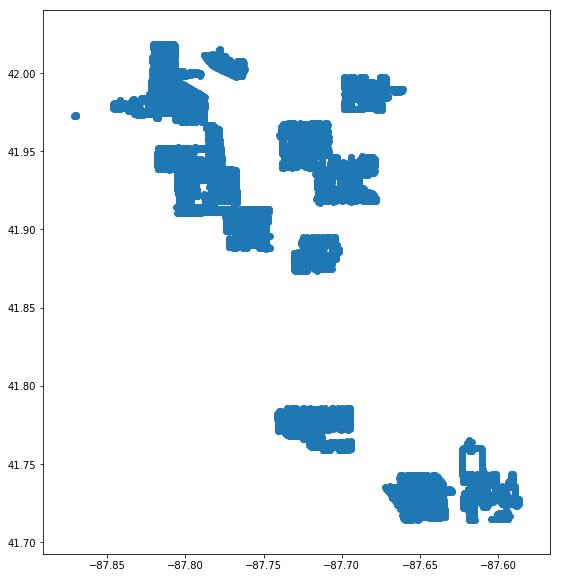

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
spray_geo.plot(ax=ax);

In [11]:
# neato

### Now what? Couldn't we have plotted that through Pandas?

Yes. But, GeoPandas lets you interact with the data in a way that Pandas can't

### Teaching the data where it is in the world

In [12]:
spray_geo.crs = {'init' :'epsg:4326'}
# epsg:4326 is a Coordinate Reference System

### Convert the coordinates to polygons

In [13]:
# check to see which date has the most data
spray_geo.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
Name: Date, dtype: int64

In [14]:
from shapely.geometry import Polygon

In [15]:
# making a separate dataframe to work with
aug_15 = spray_geo[spray_geo["Date"]=="2013-08-15"]

In [16]:
aug_15.head()

,Date,Time,Latitude,Longitude,coordinates
7213,2013-08-15,8:18:38 PM,41.944718,-87.808187,POINT (-87.8081866666667 41.9447183333333)
7214,2013-08-15,8:18:58 PM,41.944125,-87.808177,POINT (-87.8081766666667 41.944125)
7215,2013-08-15,8:19:08 PM,41.943768,-87.808162,POINT (-87.80816166666669 41.9437683333333)
7216,2013-08-15,8:19:18 PM,41.943405,-87.808153,POINT (-87.80815333333331 41.943405)
7217,2013-08-15,8:19:28 PM,41.942983,-87.808135,POINT (-87.80813499999999 41.9429833333333)


In [17]:
# new polygon object that has polygon'ed coordinates
aug_15_geom = Polygon(zip(aug_15.Longitude, aug_15.Latitude))
type(aug_15_geom)

shapely.geometry.polygon.Polygon

In [18]:
# setting a gpd dataframe from the polygon object
polygon1 = gpd.GeoDataFrame(index=[0], geometry=[aug_15_geom])       

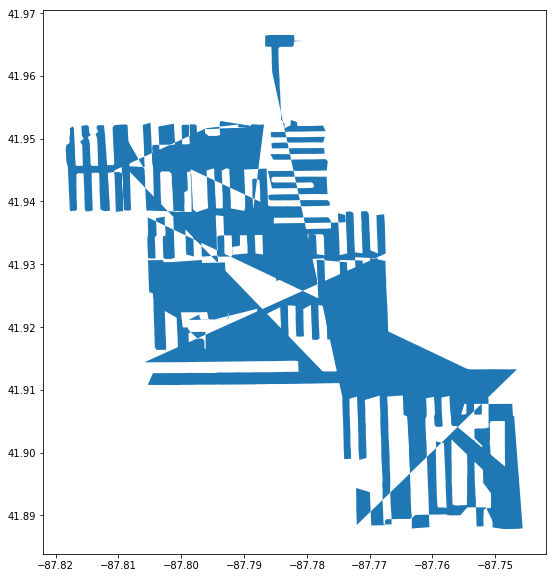

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
polygon1.plot(ax=ax)

The polygon function will try to make continuous shapes based on the coordinates you feed it. This particular shape looks super weird because the coordinates are wonky, but you can definitely make out the general idea of what's going on

Let's try it again with all the coordinates

In [20]:
full_geom = Polygon(zip(spray_geo.Longitude, spray_geo.Latitude))
polygon = gpd.GeoDataFrame(index=[0], geometry=[full_geom])

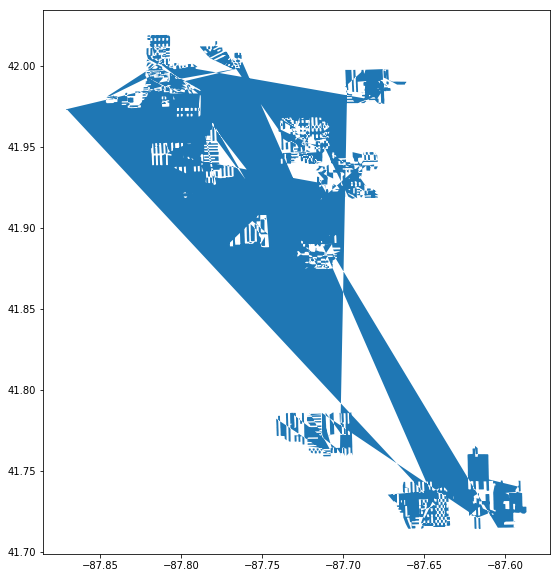

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
polygon.plot(ax=ax)

This is ugly, but it would probably work if we separated out each instance of spraying. Would it work better if we just had really simple shapes?

Surely

In [22]:
gpdf = gpd.GeoDataFrame([["pt1", Point(2,0)],
                        ["pt2", Point(4,0)],
                        ["pt3", Point(5,2)],
                        ["pt4", Point(3,5)],
                        ["pt5", Point(1,1)]],
                        columns=["point", "geometry"],
                        geometry="geometry")

In [23]:
gpdf

,point,geometry
0,pt1,POINT (2 0)
1,pt2,POINT (4 0)
2,pt3,POINT (5 2)
3,pt4,POINT (3 5)
4,pt5,POINT (1 1)


In [24]:
gpdf['coords'] = gpdf['geometry'].apply(lambda x: x.coords[0])
# explain the lambda fnc

In [25]:
gpdf

,point,geometry,coords
0,pt1,POINT (2 0),"(2.0, 0.0)"
1,pt2,POINT (4 0),"(4.0, 0.0)"
2,pt3,POINT (5 2),"(5.0, 2.0)"
3,pt4,POINT (3 5),"(3.0, 5.0)"
4,pt5,POINT (1 1),"(1.0, 1.0)"


In [26]:
# makin' a polygon
shape = Polygon(gpdf.coords)

In [27]:
# makin' a dataframe out of the polygon
shape_gpd = gpd.GeoDataFrame(index=[0], geometry=[shape])

In [28]:
shape_gpd

,geometry
0,"POLYGON ((2 0, 4 0, 5 2, 3 5, 1 1, 2 0))"


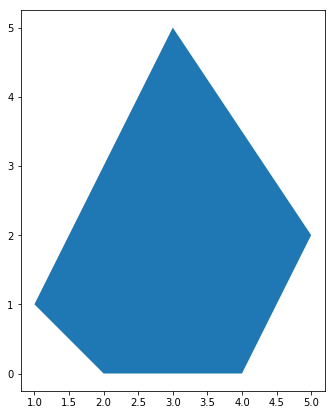

In [45]:
fig, ax = plt.subplots(figsize=(7,7))
shape_gpd.plot(ax=ax)

In [31]:
new_gpdf = gpd.GeoDataFrame([["pt1", Point(2,1)],
                        ["pt2", Point(4,1)],
                        ["pt3", Point(4,4)],
                        ["pt4", Point(2,4)]],
                        columns=["point", "geometry"],
                        geometry="geometry")

new_gpdf['coords'] = new_gpdf['geometry'].apply(lambda x: x.coords[0])
shape2 = Polygon(new_gpdf.coords)
shape2_gpd = gpd.GeoDataFrame(index=[0], geometry=[shape2])

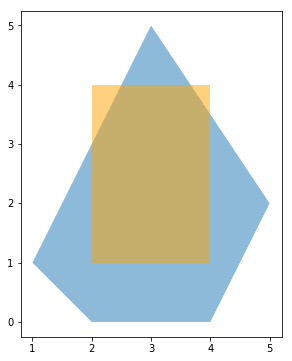

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
shape_gpd.plot(ax=ax, alpha=.5)
shape2_gpd.plot(ax=ax, color="orange", alpha=.5)
# ax = shape_gpd.plot(alpha=.5)
# shape2_gpd.plot(ax=ax, color="g", alpha=.5)

You can even calculate the % overlap

In [33]:
for index1, shp1 in enumerate(shape_gpd["geometry"]):
    for index2, shp2 in enumerate(shape2_gpd["geometry"]):
        if shp1.intersects(shp2):
            print(index1, index2, (shp1.intersection(shp2).area/shp1.area)*100)

0 0 49.275362318840585


### Saving shape files for other uses

Let's say you want to save your coordinates to use later, or load up with another package. Luckily, you can save data as shape files, which you could then open with something like PySAL (which we used in class)

In [34]:
spray_geo.to_file(driver = 'ESRI Shapefile', filename= "spray_geo.shp")
# that's literally it. super easy

One thing to keep in mind is that a shape file can't save a DataFrame that has an integer for a column name

##### Opening with PySAL

In [35]:
ps_spray = ps.open("./spray_geo.shp")
# once you have a shapefile, you can read it any way you want

In [36]:
list(ps_spray)

[(-87.7877766666667, 41.9814333333333),
 (-87.7877783333333, 41.9809983333333),
 (-87.7877616666667, 41.98056),
 (-87.7877583333333, 41.9801983333333),
 (-87.78776500000001, 41.9797516666667),
 (-87.7877533333333, 41.9793516666667),
 (-87.7877633333333, 41.97885),
 (-87.7877733333333, 41.978398333333296),
 (-87.78775999999999, 41.977990000000005),
 (-87.7877783333333, 41.977495000000005),
 (-87.78783666666669, 41.975373333333295),
 (-87.7878416666667, 41.9748233333333),
 (-87.7878666666667, 41.9742833333333),
 (-87.78788, 41.97381),
 (-87.78788, 41.9733533333333),
 (-87.7878933333333, 41.972905),
 (-87.7878933333333, 41.972446666666706),
 (-87.7879216666667, 41.9719183333333),
 (-87.7879283333333, 41.9713833333333),
 (-87.78792, 41.970898333333295),
 (-87.7879466666667, 41.9704),
 (-87.7879616666667, 41.96987),
 (-87.7879783333333, 41.96934),
 (-87.78869499999999, 41.9685533333333),
 (-87.7891083333333, 41.9685566666667),
 (-87.7891483333333, 41.9687633333333),
 (-87.789165, 41.9688666